In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import numpy as np
import pandas as pd
import spotlob
import tifffile as tf
import matplotlib.pyplot as plt
import imageio as im
import cv2

In [3]:
from PIL import Image

In [4]:
from spotlob.process_steps import Reader
from spotlob.parameters import NumericRangeParameter
from spotlob.spim import Spim

In [5]:
class TifReader(Reader):
    """
    Reads an image from a file as an RGB file.
    Only image format `tif` is supported.
    It uses `tifffile.memmap`.
    """

    def __init__(self, filepath):
        if os.path.exists(filepath):
            im = Image.open(filepath)
            xpix, ypix = im.size
        else:
            raise IOError(f"File {filepath} not found")
        pars = [NumericRangeParameter("width", xpix, 0, xpix), 
                NumericRangeParameter("height", ypix, 0, ypix),
                NumericRangeParameter("startingpoint", (0, 0), (0, 0), (xpix, ypix))]
        super(TifReader, self).__init__(self.partial_read, pars)
        self.xpix = xpix
        self.ypix = ypix

    def partial_read(self, filepath, 
                     x_percent= 100, 
                     y_percent= 100, 
                     startingpoint= (0, 0), 
                     width= 0, 
                     height= 0): # -> tuple(np.ndarray, dict)
        """
        Returns an array of a part of an .tif image.
        The arguments must be percentages, even the startingpoint is relative.
        Starting Point is the top-left corner.
        """
        if os.path.exists(filepath):
            width, height = self.xpix, self.ypix
            new_xpix = width * x_percent // 100
            new_ypix = height * y_percent // 100
            rel_start_x = width * startingpoint[0] // 100
            rel_start_y = height * startingpoint[1] // 100
            return (tf.memmap(filepath, dtype= np.uint8)[rel_start_y: rel_start_y + new_ypix, \
                                                         rel_start_x: rel_start_x + new_xpix, :], \
                    {"startingpoint": startingpoint, "original_width": width, "original_height": height})
        else:
            raise IOError(f"File {filepath} not found")
    
    def preview(self, spim):
        width, height = self.parameters["width"].value, self.parameters["height"].value
        startingpoint = self.parameters["startingpoint"].value
        filepath = spim.metadata["filepath"]
        if os.path.exists(filepath):
            image = tf.memmap(filepath, dtype= np.uint8)
            partial_image = self.partial_read(filepath, width//4, height//4*3, startingpoint)[0]
        else:
            raise IOError(f"File {filepath} not found!")
        image = image // 10
        image[startingpoint[1]:height+startingpoint[1], startingpoint[0]:width+startingpoint[0], :] = partial_image
        return image

In [6]:
# Creates a testtif.tif image
width = 1000
height = 1000
array = np.zeros([height, width, 3], dtype= np.uint8)
array[:height//2,:width//2] = [255, 0, 0]
array[:height//2,width//2:] = [0, 0, 255]   
array[height//2:,:width//2] = [255, 100, 255] 
array[height//2:,width//2:] = [100, 100, 255]
im.imwrite("testtif.tif", array)

In [7]:
h = TifReader("testtif.tif")
test_spim = Spim.from_file("testtif.tif")
print(test_spim._image)
print(test_spim.metadata)
print(test_spim.stage)
print(test_spim.cached)

None
{'filepath': 'testtif.tif'}
0
False


{'startingpoint': (40, 40), 'original_width': 1000, 'original_height': 1000}


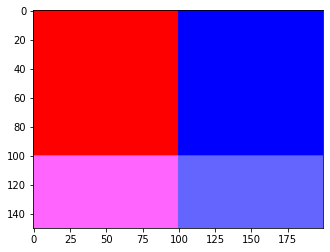

In [8]:
# %matplotlib widget
array, metadata = h.partial_read("testtif.tif", 20, 15, (40, 40))
plt.imshow(array)
print(metadata)

In [9]:
test_spim.read(h)

<Spim instance 2353367534128 at stage 1>

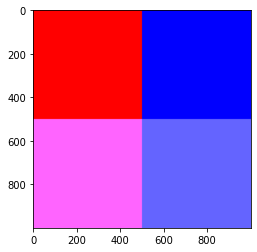

In [10]:
# h.preview(test_spim)
plt.imshow(h.preview(test_spim))

In [11]:
from spotlob.defaults import default_pipeline
filename = "testtif.tif"

In [12]:
gui = spotlob.make_gui(filename)

In [13]:
gui.pipeline = gui.pipeline.replaced_with(TifReader)

In [14]:
spotlob.show_gui(gui)

AttributeError: 'str' object has no attribute 'function'